<a href="https://colab.research.google.com/github/Cyfraice/QuantumAI/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuratezza SVM: 80.00%
Epoca 1/10: Costo = 0.7540, Accuratezza allenamento = 57.14%, Accuratezza test = 66.67%
Epoca 2/10: Costo = 0.7533, Accuratezza allenamento = 57.14%, Accuratezza test = 66.67%
Epoca 3/10: Costo = 0.7526, Accuratezza allenamento = 57.14%, Accuratezza test = 66.67%
Epoca 4/10: Costo = 0.7520, Accuratezza allenamento = 57.14%, Accuratezza test = 66.67%
Epoca 5/10: Costo = 0.7513, Accuratezza allenamento = 57.14%, Accuratezza test = 66.67%
Epoca 6/10: Costo = 0.7506, Accuratezza allenamento = 57.14%, Accuratezza test = 66.67%
Epoca 7/10: Costo = 0.7500, Accuratezza allenamento = 57.14%, Accuratezza test = 66.67%
Epoca 8/10: Costo = 0.7493, Accuratezza allenamento = 57.14%, Accuratezza test = 66.67%
Epoca 9/10: Costo = 0.7487, Accuratezza allenamento = 57.14%, Accuratezza test = 65.00%
Epoca 10/10: Costo = 0.7480, Accuratezza allenamento = 57.14%, Accuratezza test = 65.00%
Accuratezza Modello Quantistico: 65.00%
Accuratezza SVM con caratteristiche quantistiche: 85.00

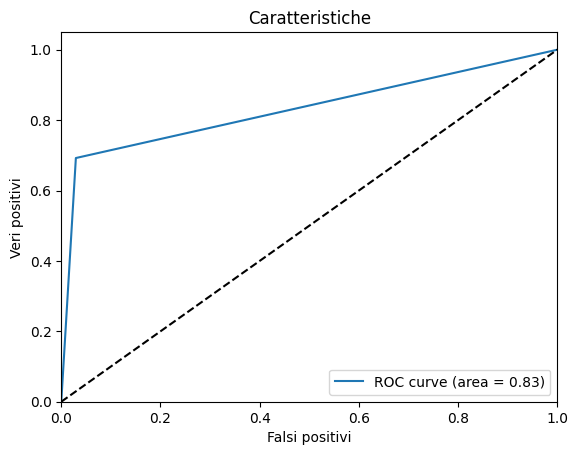

In [31]:
# !pip install pennylane
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# device = qml.device('rigetti.qvm', device='my_device_name', wires=4)
#'qiskit.ibmq','rigetti.qvm','ionq'

#simulatore locale
device = qml.device('default.qubit', wires=4)


def generate_data(num_samples=100):
    X = []
    y = []

    for _ in range(num_samples):
        # Dati per il flusso ordinato
        ordinato = np.random.normal(loc=0.0, scale=0.1, size=(2,))
        X.append(ordinato)
        y.append(0)  # Etichetta 0 per ordinato

        # Dati per flusso caotico
        caotico = np.random.normal(loc=0.5, scale=1.0, size=(2,))
        X.append(caotico)
        y.append(1)  # Etichetta 1 per caotico

    return np.array(X), np.array(y)

# dataset
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Allenamento SVM
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

#accuratezza
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"Accuratezza SVM: {svm_accuracy * 100:.2f}%")


# Dispositivo PennyLane (simulatore di qubit)
dev = qml.device("default.qubit", wires=4)  # 4 qubit

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Circuito quantistico con Hadamard, rotazioni e Entanglement
    for i in range(4):
        qml.Hadamard(wires=i)

    qml.RZ(inputs[0], wires=0)
    qml.RZ(inputs[1], wires=1)

    num_layers = int(len(weights) / (4 * 3))

    for l in range(num_layers):
        for i in range(4):
            qml.Rot(weights[l * 12 + i * 3], weights[l * 12 + i * 3 + 1], weights[l * 12 + i * 3 + 2], wires=i)

        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[2, 3])

    return [qml.expval(qml.PauliZ(i)) for i in range(4)]


def quantum_model(inputs, weights):
    result = quantum_circuit(inputs, weights)
    return 1 / (1 + np.exp(-result[0]))  # Sigmoide


# Funzione di costo per l'allenamento
def cost(weights, X, y, lambda_reg=0.01):
    predictions = [(quantum_model(x, weights)) for x in X]
    probabilities = (np.array(predictions) + 1) / 2
    log_likelihood = -np.mean(y * np.log(probabilities) + (1 - y) * np.log(1 - probabilities))
    l2_reg = lambda_reg * np.sum(weights ** 2)
    return log_likelihood + l2_reg

# Pesi casuali
weights = np.random.randn(12, requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.005)

epochs = 10
lambda_reg = 0.0001

cost_values = []
weights_values = []  # Lista per i pesi

for epoch in range(epochs):
    epoch_cost = cost(weights, X_train, y_train, lambda_reg)
    cost_values.append(epoch_cost)

    weights = opt.step(lambda w: cost(w, X_train, y_train, lambda_reg), weights)

    weights_values.append(weights.numpy())

    train_accuracy = accuracy_score(y_train, [1 if quantum_model(x, weights) > 0.5 else 0 for x in X_train])
    test_accuracy = accuracy_score(y_test, [1 if quantum_model(x, weights) > 0.5 else 0 for x in X_test])

    print(f"Epoca {epoch+1}/{epochs}: Costo = {epoch_cost:.4f}, Accuratezza allenamento = {train_accuracy*100:.2f}%, Accuratezza test = {test_accuracy*100:.2f}%")


weights_array = np.array(weights_values)


# Predizione
quantum_predictions = [1 if quantum_model(x, weights) > 0.5 else 0 for x in X_test]
# Accuratezza modello quantistico
quantum_accuracy = accuracy_score(y_test, quantum_predictions)
print(f"Accuratezza Modello Quantistico: {quantum_accuracy * 100:.2f}%")

# Caratteristiche quantistiche
def generate_quantum_features(X, weights):
    return np.array([quantum_model(x, weights) for x in X])

X_train_quantum = generate_quantum_features(X_train, weights).reshape(-1, 1)
X_test_quantum = generate_quantum_features(X_test, weights).reshape(-1, 1)


# Allenamento SVM usando le caratteristiche quantistiche
svm_quantum = SVC(kernel="rbf")  # oppure 'poly', 'linear'
svm_quantum.fit(X_train_quantum, y_train)

svm_predictions = svm_quantum.predict(X_test_quantum)

# Accuratezza
svm_quantum_accuracy = accuracy_score(y_test, svm_predictions)
print(f"Accuratezza SVM con caratteristiche quantistiche: {svm_quantum_accuracy * 100:.2f}%")

# Confronto delle accuratezze
print("\nConfronto delle accuratezze:")
print(f" - Modello SVM: {svm_accuracy * 100:.2f}%")
print(f" - Modello Quantistico: {quantum_accuracy * 100:.2f}%")
print(f" - Modello SVM con caratteristiche quantistiche: {svm_quantum_accuracy * 100:.2f}%")



# Matrice di confusione
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, svm_predictions)
print(confusion_matrix)

# Curva ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, svm_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsi positivi')
plt.ylabel('Veri positivi')
plt.title('Caratteristiche')
plt.legend(loc="lower right")
plt.show()




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                   Metric  SVM Classico  SVM + Feature Quantistiche
0                Accuracy      0.680000                    0.500000
1   Precision (Lamellare)      0.609756                    0.000000
2      Recall (Lamellare)      1.000000                    0.000000
3          F1 (Lamellare)      0.757576                    0.000000
4  Precision (Turbolento)      1.000000                    0.500000
5     Recall (Turbolento)      0.360000                    1.000000
6         F1 (Turbolento)      0.529412                    0.666667


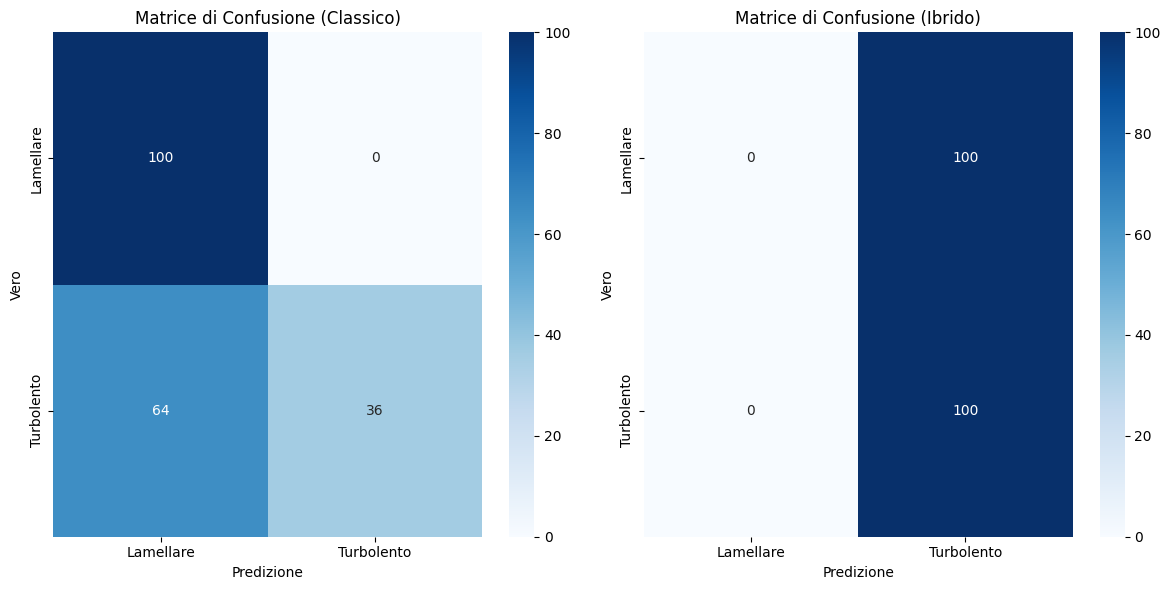

                   Metric  SVM Classico  SVM + Feature Quantistiche
0                Accuracy      0.710000                    0.863333
1   Precision (Lamellare)      0.652000                    0.799020
2      Recall (Lamellare)      1.000000                    1.000000
3          F1 (Lamellare)      0.789346                    0.888283
4  Precision (Turbolento)      1.000000                    1.000000
5     Recall (Turbolento)      0.364964                    0.700730
6         F1 (Turbolento)      0.534759                    0.824034


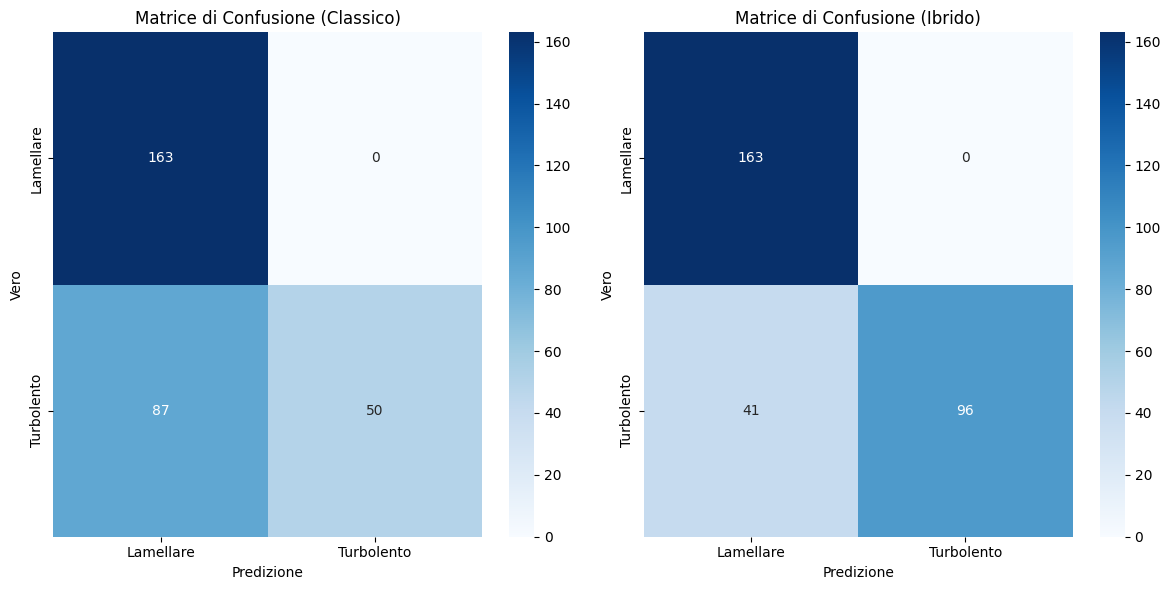

In [ ]:
# !pip install pennylane
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pennylane as qml
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns

Lx, Ly, Lz = 10.0, 10.0, 10.0  # Dimensioni del dominio
Nx, Ny, Nz = 32, 32, 32  # Risoluzione griglia
dx, dy, dz = Lx / Nx, Ly / Ny, Lz / Nz
nu = 0.01  # Viscosità cinematica
dt = 0.01  # Passo temporale
steps = 100  # Numero di passi temporali

def simulate_flow(Nx, Ny, Nz, nu, dt, steps, turbulent=False):
    u = np.zeros((Nx, Ny, Nz))
    v = np.zeros((Nx, Ny, Nz))
    w = np.zeros((Nx, Ny, Nz))

    if turbulent:
        # Genera rumore che evolve nel tempo
        u = np.random.randn(Nx, Ny, Nz) * 0.1
        v = np.random.randn(Nx, Ny, Nz) * 0.1
        w = np.random.randn(Nx, Ny, Nz) * 0.1

        # Aggiungere rumore temporale a simulazione
        for step in range(steps):
            noise_u = np.random.randn(Nx, Ny, Nz) * 0.05
            noise_v = np.random.randn(Nx, Ny, Nz) * 0.05
            noise_w = np.random.randn(Nx, Ny, Nz) * 0.05

            u += noise_u * dt
            v += noise_v * dt
            w += noise_w * dt
    else:
        u = np.ones((Nx, Ny, Nz)) * 0.1
        v = np.zeros((Nx, Ny, Nz))
        w = np.zeros((Nx, Ny, Nz))

    for _ in range(steps):
        grad_u = np.gradient(u, dx, axis=0), np.gradient(u, dy, axis=1), np.gradient(u, dz, axis=2)
        grad_v = np.gradient(v, dx, axis=0), np.gradient(v, dy, axis=1), np.gradient(v, dz, axis=2)
        grad_w = np.gradient(w, dx, axis=0), np.gradient(w, dy, axis=1), np.gradient(w, dz, axis=2)

        laplacian_u = np.gradient(grad_u[0], dx, axis=0) + np.gradient(grad_u[1], dy, axis=1) + np.gradient(grad_u[2], dz, axis=2)
        laplacian_v = np.gradient(grad_v[0], dx, axis=0) + np.gradient(grad_v[1], dy, axis=1) + np.gradient(grad_v[2], dz, axis=2)
        laplacian_w = np.gradient(grad_w[0], dx, axis=0) + np.gradient(grad_w[1], dy, axis=1) + np.gradient(grad_w[2], dz, axis=2)

        u += nu * laplacian_u * dt
        v += nu * laplacian_v * dt
        w += nu * laplacian_w * dt

    return u, v, w

# Dataset
def generate_dataset(samples):
    data = []
    labels = []
    for _ in range(samples):
        # Variazione casuale di parametri
        nu_varied = np.random.uniform(0.005, 0.05)  # Viscosità
        dt_varied = np.random.uniform(0.005, 0.05)  # Passo temporale
        steps_varied = np.random.randint(50, 200)  # Passi temporali
        is_turbulent = np.random.rand() > 0.5 #?

        u, v, w = simulate_flow(Nx, Ny, Nz, nu_varied, dt_varied, steps_varied, turbulent=is_turbulent)

        # Estrarre feature: energia cinetica media
        energy = np.mean(u**2 + v**2 + w**2)
        data.append(energy)
        labels.append(1 if is_turbulent else 0)
    return np.array(data), np.array(labels)



dev = qml.device("default.qubit", wires=4)

# Circuito quantistico per ottenere le caratteristiche quantistiche
@qml.qnode(dev)
def quantum_circuit(inputs):
    for i in range(4):
        qml.Hadamard(wires=i)  # Operatore Hadamard sui qubit

    # Codifica degli input
    qml.RZ(inputs[0], wires=0)
    qml.RZ(inputs[1], wires=1)

    # Strati di rotazione
    qml.RX(inputs[0], wires=2)
    qml.RX(inputs[1], wires=3)

    return [qml.expval(qml.PauliZ(i)) for i in range(4)] + \
            [qml.expval(qml.PauliX(i)) for i in range(4)] + \
            [qml.expval(qml.PauliY(i)) for i in range(4)]

# Funzione per ottenere le caratteristiche quantistiche da un dato
def generate_quantum_features(X):
    features = []
    for x in X:
        x = np.array([x, x])
        features.append(quantum_circuit(x))
    return np.array(features)




#DATI

# Dataset
X, y = generate_dataset(1000)

# Divisione in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Generazione delle *feature* quantistiche
X_train_quantum = generate_quantum_features(X_train)
X_test_quantum = generate_quantum_features(X_test)



#SVM
scaler = StandardScaler()
X_train_quantum_scaled = scaler.fit_transform(X_train_quantum)
X_test_quantum_scaled = scaler.transform(X_test_quantum)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

svm_model = SVC(kernel='rbf', random_state=42, C=1.0, gamma='scale')  # Puoi sperimentare con C e gamma
svm_model.fit(X_train, y_train)

svm_model_quantum = SVC(kernel='rbf', random_state=42, C=1.0, gamma='scale')
svm_model_quantum.fit(X_train_quantum_scaled, y_train)


#CONFRONTO SVM CON QSVM


y_pred_svm_classic = svm_model.predict(X_test)  # Classico
y_pred_svm_quantum = svm_model_quantum.predict(X_test_quantum)  # Ibrido


# Calcolo delle metriche
accuracy_classic = accuracy_score(y_test, y_pred_svm_classic)
report_classic = classification_report(y_test, y_pred_svm_classic, output_dict=True)
cm_classic = confusion_matrix(y_test, y_pred_svm_classic)

accuracy_quantum = accuracy_score(y_test, y_pred_svm_quantum)
report_quantum = classification_report(y_test, y_pred_svm_quantum, output_dict=True)
cm_quantum = confusion_matrix(y_test, y_pred_svm_quantum)



comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Lamellare)', 'Recall (Lamellare)', 'F1 (Lamellare)',
               'Precision (Turbolento)', 'Recall (Turbolento)', 'F1 (Turbolento)'],
    'SVM Classico': [
        accuracy_classic,
        report_classic['0']['precision'], report_classic['0']['recall'], report_classic['0']['f1-score'],
        report_classic['1']['precision'], report_classic['1']['recall'], report_classic['1']['f1-score']
    ],
    'SVM + Feature Quantistiche': [
        accuracy_quantum,
        report_quantum['0']['precision'], report_quantum['0']['recall'], report_quantum['0']['f1-score'],
        report_quantum['1']['precision'], report_quantum['1']['recall'], report_quantum['1']['f1-score']
    ]
})

print(comparison_table)

# Opzionale: Visualizzare anche le matrici di confusione


# Matrice di confusione per SVM classico
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_classic, annot=True, fmt='d', cmap='Blues', xticklabels=['Lamellare', 'Turbolento'], yticklabels=['Lamellare', 'Turbolento'])
plt.title('Matrice di Confusione (Classico)')
plt.xlabel('Predizione')
plt.ylabel('Vero')

# Matrice di confusione per SVM + Feature Quantistiche
plt.subplot(1, 2, 2)
sns.heatmap(cm_quantum, annot=True, fmt='d', cmap='Blues', xticklabels=['Lamellare', 'Turbolento'], yticklabels=['Lamellare', 'Turbolento'])
plt.title('Matrice di Confusione (Ibrido)')
plt.xlabel('Predizione')
plt.ylabel('Vero')

plt.tight_layout()
plt.show()




#TEST


# Generazione di un dataset di esempio (assicurati che questa funzione esista)
new_X, new_y = generate_dataset(1000)  # Funzione generica per generare dati di esempio
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_X, new_y, test_size=0.3, random_state=42)

X_train_quantum_new = generate_quantum_features(X_train_new)
X_test_quantum_new = generate_quantum_features(X_test_new)



#SVM

scaler = StandardScaler()
X_train_quantum_scaled_new = scaler.fit_transform(X_train_quantum_new)
X_test_quantum_scaled_new = scaler.transform(X_test_quantum_new)


X_train_new = X_train_new.reshape(-1, 1)
X_test_new = X_test_new.reshape(-1, 1)



#CONFRONTO SVM CON QSVM

y_pred_svm_classic = svm_model.predict(X_test_new)  # Classico
y_pred_svm_quantum = svm_model_quantum.predict(X_test_quantum_scaled_new)  # Ibrido

accuracy_classic = accuracy_score(y_test_new, y_pred_svm_classic)  # Use y_test_new
report_classic = classification_report(y_test_new, y_pred_svm_classic, output_dict=True)  # Use y_test_new
cm_classic = confusion_matrix(y_test_new, y_pred_svm_classic)  # Use y_test_new

accuracy_quantum = accuracy_score(y_test_new, y_pred_svm_quantum)  # Use y_test_new
report_quantum = classification_report(y_test_new, y_pred_svm_quantum, output_dict=True)  # Use y_test_new
cm_quantum = confusion_matrix(y_test_new, y_pred_svm_quantum)  # Use y_test_new

comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Lamellare)', 'Recall (Lamellare)', 'F1 (Lamellare)',
               'Precision (Turbolento)', 'Recall (Turbolento)', 'F1 (Turbolento)'],
    'SVM Classico': [
        accuracy_classic,
        report_classic['0']['precision'], report_classic['0']['recall'], report_classic['0']['f1-score'],
        report_classic['1']['precision'], report_classic['1']['recall'], report_classic['1']['f1-score']
    ],
    'SVM + Feature Quantistiche': [
        accuracy_quantum,
        report_quantum['0']['precision'], report_quantum['0']['recall'], report_quantum['0']['f1-score'],
        report_quantum['1']['precision'], report_quantum['1']['recall'], report_quantum['1']['f1-score']
    ]
})

print(comparison_table)

# Matrice di confusione Classico
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_classic, annot=True, fmt='d', cmap='Blues', xticklabels=['Lamellare', 'Turbolento'], yticklabels=['Lamellare', 'Turbolento'])
plt.title('Matrice di Confusione (Classico)')
plt.xlabel('Predizione')
plt.ylabel('Vero')

# Matrice di confusione Ibrido
plt.subplot(1, 2, 2)
sns.heatmap(cm_quantum, annot=True, fmt='d', cmap='Blues', xticklabels=['Lamellare', 'Turbolento'], yticklabels=['Lamellare', 'Turbolento'])
plt.title('Matrice di Confusione (Ibrido)')
plt.xlabel('Predizione')
plt.ylabel('Vero')

plt.tight_layout()
plt.show()